## DATA IMPORTING

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math

In [8]:
df1 = pd.read_csv('train.csv').dropna() #Training Dataset
df2 = pd.read_csv('test.csv') #Testing dataset
codf = pd.read_csv('US_COVID_data_state_level.csv') #Covid data of cities
cidf = pd.read_csv('city_details.csv') #Cities data
wadf = pd.read_csv('warehouse_mapping.csv')
co = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
holiday_df = pd.read_csv("US Holiday Dates (2004-2021).csv")

In [9]:
df1['date']=pd.to_datetime(df1.date)
df2['date']=pd.to_datetime(df2.date)
co.rename(columns={'submission_date':'date'},inplace=True)
co['date']=pd.to_datetime(co.date)
df1.sort_values('date',inplace = True)
df1.index = np.arange(df1.shape[0])
codf['date']=pd.to_datetime(codf.date)
codf.sort_values('date',inplace = True)
codf.index = np.arange(codf.shape[0])

## Predicting Confirmed Cases

In [10]:
corl = codf[codf.conf_cases.notna()] #Non-empty cells of confirmed cases

In [11]:
a,b = np.array(list(corl.tot_cases)),np.array(list(corl.conf_cases))

In [12]:
pd.Series(a).corr(pd.Series(b))

0.994857188030104

#### Already we see a high correlation in tot_cases and conf cases. So, we use only tot_cases data.

## DATA CLEANING

In [13]:
cidf1 = cidf.drop(['country'],axis = 1) #dropping useless columns
cidf1 = cidf1.drop_duplicates()
cidf1.tail(),cidf1.shape

(            city  zip_code state  state_name
 554  WESTMINSTER     92683    CA  CALIFORNIA
 555      ONTARIO     91761    CA  CALIFORNIA
 556       TACOMA     98409    WA  WASHINGTON
 557      BOZEMAN     59718    MT     MONTANA
 558    CLACKAMAS     97015    OR      OREGON,
 (555, 4))

In [14]:
value,counts = np.unique(cidf1.zip_code,return_counts=True)
value[counts>1],counts[counts>1]

(array([94080, 98027], dtype=int64), array([2, 2], dtype=int64))

In [15]:
cidf1[cidf1.zip_code == 94080]

,city,zip_code,state,state_name
370,S,94080,CA,CALIFORNIA
371,EL,94080,CA,CALIFORNIA


In [16]:
cidf1[cidf1.zip_code == 98027]

,city,zip_code,state,state_name
69,ISSAQUAH,98027,WA,WASHINGTON
70,US,98027,WA,WASHINGTON


In [17]:
cidf1.drop(index=371,inplace=True)
cidf1.drop(index=70,inplace=True)

In [18]:
uszips = pd.read_csv('uszips.csv')
cidf1 = cidf1.merge(uszips[['zip','population']],how='left',right_on='zip',left_on='zip_code')

In [19]:
uszips['city']=uszips['city'].apply(lambda x: x.upper())

In [20]:
state = cidf1.state.unique()
num_cities = [cidf1[cidf1.state == st].zip_code.nunique() for st in state]
tot_population_state = [cidf1[cidf1.state==st].population.sum() for st in state]
stct = pd.DataFrame({'state':state,'num_cities':num_cities})
stpop = pd.DataFrame({'state':state,'tot_population_state':tot_population_state})

In [21]:
cidf_final = cidf1.merge(stct,on = 'state',how = 'left').merge(stpop,on='state',how='left')
cidf_final.fillna(cidf_final.mean(numeric_only=True),inplace=True)

In [22]:
b = []
for row in wadf.values:
  b.append(row[1].split()[2]) #taking 3rd word from warehouse_name which is city

wadf['city'] = np.array(b)
wadf.sample(5)

,wh_id,warehouse_name,city
291,319,WAREHOUSE 319 DEDHAM,DEDHAM
471,663,WAREHOUSE 663 CONCORD,CONCORD
461,651,WAREHOUSE 651 ORLANDO BUS CTR,ORLANDO
28,1025,WAREHOUSE 1025 MANAHAWKIN,MANAHAWKIN
182,1295,WAREHOUSE 1295 WOODSTOCK,WOODSTOCK


### MANUAL DATA CLEANING

Some of the city names existing in multiple states . Solving this is the bruteforce way . I have imported new data from trusted source using this data i have assigned new city names solving the problem to an extent.

In [23]:
sam = cidf_final.merge(uszips[['zip','city','state_id']],how='left',on='zip')

In [24]:
value,counts = np.unique(wadf.city,return_counts=True)
value[counts>1],counts[counts>1],counts[counts>1].sum()

(array(['AURORA', 'AVON', 'BURBANK', 'COLUMBIA', 'COMMERCE', 'CYPRESS',
        'DALLAS', 'E', 'EAST', 'EL', 'EVERETT', 'FORT', 'GRAND',
        'HAWTHORNE', 'HAYWARD', 'LA', 'LAGUNA', 'LAKE', 'LANCASTER',
        'LINCOLN', 'LYNNWOOD', 'MIAMI', 'MT', 'N', 'NE', 'NEW', 'NORTH',
        'NORWALK', 'NW', 'PALM', 'RANCHO', 'ROCHESTER', 'ROSEVILLE', 'S',
        'SACRAMENTO', 'SAN', 'SANTA', 'SE', 'SOUTH', 'ST', 'SW', 'TUSTIN',
        'UNION', 'W', 'WEST', 'WESTMINSTER', 'WOODLAND'], dtype=object),
 array([ 2,  2,  2,  2,  2,  2,  3,  7,  3,  3,  2,  4,  2,  2,  2,  4,  2,
         3,  2,  2,  2,  2,  4,  6,  4,  4,  3,  2,  4,  2,  3,  2,  2,  6,
         2, 10,  5,  4,  2,  5,  4,  2,  2,  8,  4,  2,  2], dtype=int64),
 151)

In [25]:
wadf[wadf.city ==  'HAYWARD']

,wh_id,warehouse_name,city
48,1061,WAREHOUSE 1061 HAYWARD,HAYWARD
546,823,WAREHOUSE 823 HAYWARD BUS CTR,HAYWARD


In [26]:
sam[sam.city_x == 'HAYWARD']

,city_x,zip_code,state,state_name,zip,population,num_cities,tot_population_state,city_y,state_id
47,HAYWARD,94545,CA,CALIFORNIA,94545,32552.0,126,5739662.0,HAYWARD,CA
540,HAYWARD,94541,CA,CALIFORNIA,94541,66182.0,126,5739662.0,HAYWARD,CA


In [27]:
cidf_final[cidf_final.city == 'TUSTIN']

,city,zip_code,state,state_name,zip,population,num_cities,tot_population_state
3,TUSTIN,92782,CA,CALIFORNIA,92782,23166.0,126,5739662.0


In [28]:
cidf_final.loc[218,'city'] = 'DALLAS GA'
cidf_final.loc[17,'city'] = 'E COLORADO SPRINGS'
cidf_final.loc[466,'city'] = 'E PLANO'
cidf_final.loc[323,'city'] = 'E JACKSONVILLE'
cidf_final.loc[329,'city'] = 'E BAYAMON'
cidf_final.loc[211,'city'] = 'E LYME'
cidf_final.loc[61,'city'] = 'E VANCOUVER WA'
cidf_final.loc[235,'city'] = 'E ORLANDO'
cidf_final.loc[139,'city'] = 'EL CENTRO'
cidf_final.loc[520,'city'] = 'EL PASO'
cidf_final.loc[92,'city'] = 'EVERETT WA'
cidf_final.loc[301,'city'] = 'EVERETT MA'
cidf_final.loc[293,'city'] = 'NORWALK CT'
cidf_final.loc[362,'city'] = 'NORWALK CA'
cidf_final.loc[89,'city'] = 'ROCHESTER MN'
cidf_final.loc[125,'city'] = 'ROCHESTER NY'
cidf_final.loc[270,'city'] = 'ROSEVILLE CA'
cidf_final.loc[357,'city'] = 'ROSEVILLE MI'
cidf_final.loc[379,'city'] = 'WESTMINSTER CO'
cidf_final.loc[548,'city'] = 'WESTMINSTER CA'
cidf_final.loc[273,'city'] = 'AVON MA'
cidf_final.loc[311,'city'] = 'AVON OH'

In [29]:
wadf.loc[220,'city'] = 'DALLAS GA'
wadf.loc[18,'city'] = 'E COLORADO SPRINGS'
wadf.loc[472,'city'] = 'E PLANO'
wadf.loc[326,'city'] = 'E JACKSONVILLE'
wadf.loc[332,'city'] = 'E BAYAMON'
wadf.loc[213,'city'] = 'E LYME'
wadf.loc[62,'city'] = 'E VANCOUVER WA'
wadf.loc[237,'city'] = 'E ORLANDO'
wadf.loc[141,'city'] = 'EL CENTRO'
wadf.loc[526,'city'] = 'EL PASO'
wadf.loc[94,'city'] = 'EVERETT WA'
wadf.loc[304,'city'] = 'EVERETT MA'
wadf.loc[296,'city'] = 'NORWALK CT'
wadf.loc[365,'city'] = 'NORWALK CA'
wadf.loc[91,'city'] = 'ROCHESTER MN'
wadf.loc[127,'city'] = 'ROCHESTER NY'
wadf.loc[273,'city'] = 'ROSEVILLE CA'
wadf.loc[360,'city'] = 'ROSEVILLE MI'
wadf.loc[384,'city'] = 'WESTMINSTER CO'
wadf.loc[554,'city'] = 'WESTMINSTER CA'
wadf.loc[276,'city'] = 'AVON MA'
wadf.loc[314,'city'] = 'AVON OH'

Below is One time run code

In [30]:
cidf_final.loc[cidf_final.city == 'AURORA','city'] = 'AURORA '+sam[sam.city_x == 'AURORA'].city_y.values
wadf.loc[wadf.city == 'AURORA','city'] = 'AURORA '+sam[sam.city_x == 'AURORA'].city_y.values

cidf_final.loc[cidf_final.city == 'DALLAS','city'] = ['DALLAS DALLAS','DALLAS DALLAS BUS CTR']
wadf.loc[wadf.city == 'DALLAS','city'] = ['DALLAS DALLAS','DALLAS DALLAS BUS CTR']

cidf_final.loc[cidf_final.city == 'BURBANK','city'] = 'BURBANK '+sam[sam.city_x == 'BURBANK'].city_y.values
wadf.loc[wadf.city == 'BURBANK','city'] = 'BURBANK '+sam[sam.city_x == 'BURBANK'].city_y.values

cidf_final.loc[cidf_final.city == 'COMMERCE','city'] = 'COMMERCE '+sam[sam.city_x == 'COMMERCE'].city_y.values
wadf.loc[wadf.city == 'COMMERCE','city'] = 'COMMERCE '+sam[sam.city_x == 'COMMERCE'].city_y.values

cidf_final.loc[cidf_final.city == 'CYPRESS','city'] = 'CYPRESS '+sam[sam.city_x == 'CYPRESS'].city_y.values
wadf.loc[wadf.city == 'CYPRESS','city'] = 'CYPRESS '+sam[sam.city_x == 'CYPRESS'].city_y.values

cidf_final.loc[cidf_final.city == 'COLUMBIA','city'] = 'COLUMBIA '+sam[sam.city_x == 'COLUMBIA'].city_y.values
wadf.loc[wadf.city == 'COLUMBIA','city'] = 'COLUMBIA '+sam[sam.city_x == 'COLUMBIA'].city_y.values

cidf_final.loc[cidf_final.city == 'EAST','city'] = 'EAST '+sam[sam.city_x == 'EAST'].city_y.values
wadf.loc[wadf.city == 'EAST','city'] = 'EAST '+sam[sam.city_x == 'EAST'].city_y.values

cidf_final.loc[cidf_final.city == 'FORT','city'] = 'FORT '+sam[sam.city_x == 'FORT'].city_y.values
wadf.loc[wadf.city == 'FORT','city'] = 'FORT '+sam[sam.city_x == 'FORT'].city_y.values

cidf_final.loc[cidf_final.city == 'GRAND','city'] = 'GRALA '+sam[sam.city_x == 'GRAND'].city_y.values
wadf.loc[wadf.city == 'GRAND','city'] = 'GRALA '+sam[sam.city_x == 'GRAND'].city_y.values

cidf_final.loc[cidf_final.city == 'LA','city'] = 'LA '+sam[sam.city_x == 'LA'].city_y
wadf.loc[wadf.city == 'LA','city'] = 'LA '+sam[sam.city_x == 'LA'].city_y.values

cidf_final.loc[cidf_final.city == 'LAKE','city'] = 'LAKE '+sam[sam.city_x == 'LAKE'].city_y
wadf.loc[wadf.city == 'LAKE','city'] = 'LAKE '+sam[sam.city_x == 'LAKE'].city_y.values

cidf_final.loc[cidf_final.city == 'MIAMI','city'] = 'MIAMI '+sam[sam.city_x == 'MIAMI'].city_y
wadf.loc[wadf.city == 'MIAMI','city'] = 'MIAMI '+sam[sam.city_x == 'MIAMI'].city_y.values

cidf_final.loc[cidf_final.city == 'MT','city'] = 'MT '+sam[sam.city_x == 'MT'].city_y
wadf.loc[wadf.city == 'MT','city'] = 'MT '+sam[sam.city_x == 'MT'].city_y.values

cidf_final.loc[cidf_final.city == 'N','city'] = 'N '+sam[sam.city_x == 'N'].city_y
wadf.loc[wadf.city == 'N','city'] = 'N '+sam[sam.city_x == 'N'].city_y.values

cidf_final.loc[cidf_final.city == 'NE','city'] = 'NE '+sam[sam.city_x == 'NE'].city_y
wadf.loc[wadf.city == 'NE','city'] = 'NE '+sam[sam.city_x == 'NE'].city_y.values

cidf_final.loc[cidf_final.city == 'NEW','city'] = 'NEW '+sam[sam.city_x == 'NEW'].city_y
wadf.loc[wadf.city == 'NEW','city'] = 'NEW '+sam[sam.city_x == 'NEW'].city_y.values

cidf_final.loc[cidf_final.city == 'NORTH','city'] = 'NORTH '+sam[sam.city_x == 'NORTH'].city_y
wadf.loc[wadf.city == 'NORTH','city'] = 'NORTH '+sam[sam.city_x == 'NORTH'].city_y.values

cidf_final.loc[cidf_final.city == 'NW','city'] = 'NW '+sam[sam.city_x == 'NW'].city_y
wadf.loc[wadf.city == 'NW','city'] = 'NW '+sam[sam.city_x == 'NW'].city_y.values

cidf_final.loc[cidf_final.city == 'PALM','city'] = 'PALM '+sam[sam.city_x == 'PALM'].city_y
wadf.loc[wadf.city == 'PALM','city'] = 'PALM '+sam[sam.city_x == 'PALM'].city_y.values

cidf_final.loc[cidf_final.city == 'RANCHO','city'] = 'RANCHO '+sam[sam.city_x == 'RANCHO'].city_y
wadf.loc[wadf.city == 'RANCHO','city'] = 'RANCHO '+sam[sam.city_x == 'RANCHO'].city_y.values

cidf_final.loc[cidf_final.city == 'WOODLAND','city'] = 'WOODLAND '+sam[sam.city_x == 'WOODLAND'].city_y
wadf.loc[wadf.city == 'WOODLAND','city'] = 'WOODLAND '+sam[sam.city_x == 'WOODLAND'].city_y.values

cidf_final.loc[cidf_final.city == 'SAN','city'] = 'SAN '+sam[sam.city_x == 'SAN'].city_y
wadf.loc[wadf.city == 'SAN','city'] = 'SAN '+sam[sam.city_x == 'SAN'].city_y.values

cidf_final.loc[cidf_final.city == 'SANTA','city'] = 'SANTA '+sam[sam.city_x == 'SANTA'].city_y
wadf.loc[wadf.city == 'SANTA','city'] = 'SANTA '+sam[sam.city_x == 'SANTA'].city_y.values

cidf_final.loc[cidf_final.city == 'SE','city'] = 'SE '+sam[sam.city_x == 'SE'].city_y
wadf.loc[wadf.city == 'SE','city'] = 'SE '+sam[sam.city_x == 'SE'].city_y.values

cidf_final.loc[cidf_final.city == 'SOUTH','city'] = 'SOUTH '+sam[sam.city_x == 'SOUTH'].city_y
wadf.loc[wadf.city == 'SOUTH','city'] = 'SOUTH '+sam[sam.city_x == 'SOUTH'].city_y.values

cidf_final.loc[cidf_final.city == 'ST','city'] = 'ST '+sam[sam.city_x == 'ST'].city_y
wadf.loc[wadf.city == 'ST','city'] = 'ST '+sam[sam.city_x == 'ST'].city_y.values

cidf_final.loc[cidf_final.city == 'SW','city'] = 'SW '+sam[sam.city_x == 'SW'].city_y
wadf.loc[wadf.city == 'SW','city'] = 'SW '+sam[sam.city_x == 'SW'].city_y.values

cidf_final.loc[cidf_final.city == 'UNION','city'] = 'UNION '+sam[sam.city_x == 'UNION'].city_y
wadf.loc[wadf.city == 'UNION','city'] = 'UNION '+sam[sam.city_x == 'UNION'].city_y.values

cidf_final.loc[cidf_final.city == 'W','city'] = 'W '+sam[sam.city_x == 'W'].city_y
wadf.loc[wadf.city == 'W','city'] = 'W '+sam[sam.city_x == 'W'].city_y.values

cidf_final.loc[cidf_final.city == 'WEST','city'] = 'WEST '+sam[sam.city_x == 'WEST'].city_y
wadf.loc[wadf.city == 'WEST','city'] = 'WEST '+sam[sam.city_x == 'WEST'].city_y.values

cidf_final.loc[cidf_final.city == 'S','city'] = ['S INDIANAPOLIS', 'S ORLANDO', 'S SAINT LOUIS','S SOUTH SAN FRANCISCO','S AUSTIN']
wadf.loc[wadf.city == 'S','city'] = ['S INDIANAPOLIS', 'S ORLANDO', 'S SAINT LOUIS','S SOUTH SAN FRANCISCO','S SOUTH SAN FRANCISCO BUS CTR','S AUSTIN']

## DATA PREPROCESSING, FEATURE ENGINEERING

In [31]:
x = df1.merge(wadf.drop(axis = 1,columns=['warehouse_name']),how='left',on = 'wh_id') #merging train df with warehouse data

In [32]:
m = co.sort_values('date')[['date','state','tot_cases','tot_death']].merge(cidf_final,how = 'left',on='state') #m is temp merged dataframe of covid data frame and city data frame
print(m.shape)
m['avg_tot_cases/num_cities'] = m['tot_cases'].div(m['num_cities'], fill_value=10)
m['avg_tot_cases/city_weight'] = m['tot_cases']*m['population']/m['tot_population_state']
m['avg_tot_death/num_cities'] = m['tot_death'].div(m['num_cities'], fill_value=10)
m['avg_tot_death/city_weight'] = m['tot_death']*m['population']/m['tot_population_state']
m.sample(5) #merging covid data and cities data using state as a common entity

(562038, 11)


,date,state,tot_cases,tot_death,city,zip_code,state_name,zip,population,num_cities,tot_population_state,avg_tot_cases/num_cities,avg_tot_cases/city_weight,avg_tot_death/num_cities,avg_tot_death/city_weight
541214,2022-09-04,IL,3696385,39370,NILES,60714.0,ILLINOIS,60714.0,29429.0,22.0,820703.0,168017.500000,132546.017457,1789.545455,1411.740581
147342,2020-10-08,NJ,217236,16161,TETERBORO,7608.0,NEW JERSEY,7608.0,110.0,20.0,627844.0,10861.800000,38.060346,808.050000,2.831452
219073,2021-02-12,ID,167225,1796,BOISE,83709.0,IDAHO,83709.0,60449.0,7.0,337544.0,23889.285714,29947.455813,256.571429,321.636302
250649,2021-04-08,CA,3588152,58788,CLOVIS,93612.0,CALIFORNIA,93612.0,35475.0,126.0,5739662.0,28477.396825,22177.210470,466.571429,363.349671
521289,2022-07-31,MT,296599,3473,KALISPELL,59901.0,MONTANA,59901.0,56951.0,5.0,189101.0,59319.800000,89325.861043,694.600000,1045.953342


In [33]:
z = x.merge(m,how='left', on = ['date','city']) # This is the final merged dataframe

In [85]:
#precovid data
# precov = z[z.state.isna()][['date','wh_id','sales','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight','tot_death',
#                             'avg_tot_death/num_cities','avg_tot_death/city_weight']].fillna(0)
cov = z[z.state.notna()][['date','wh_id','sales','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight','tot_death',
                           'avg_tot_death/num_cities','avg_tot_death/city_weight']]
# precov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)
# cov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)

In [86]:
df11 = df1.merge(wadf,on='wh_id',how='left').merge(cidf_final,on='city',how='left')

In [87]:
precov = df11.iloc[:225545]

In [88]:
precov[['date','state','wh_id','sales']].to_csv('precov_train.csv',index=False)

In [89]:
## Train data

z_train=z[['date','wh_id','sales','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight','tot_death',
                            'avg_tot_death/num_cities','avg_tot_death/city_weight']].fillna(0)

## Test data
x_test = df2.merge(wadf.drop(axis = 1,columns=['warehouse_name']),how='left',on = 'wh_id')
z_test = x_test.merge(m,how='left', on = ['date','city'])[['date','wh_id','tot_cases','avg_tot_cases/num_cities','avg_tot_cases/city_weight',
                                                           'tot_death','avg_tot_death/num_cities','avg_tot_death/city_weight']].fillna(0)

In [90]:
z_test.shape,df2.shape

((34831, 8), (34099, 2))

## EDA

In [91]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (25, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [92]:
def week_avg_wh_id(wh_id):
    week_avg = []
    start = 0
    shape = df1[df1.wh_id == wh_id].shape[0]
    while start<shape:
        week_avg.append(df1[df1.wh_id == wh_id][start:start+7].sales.mean())
        start += 7
    return week_avg

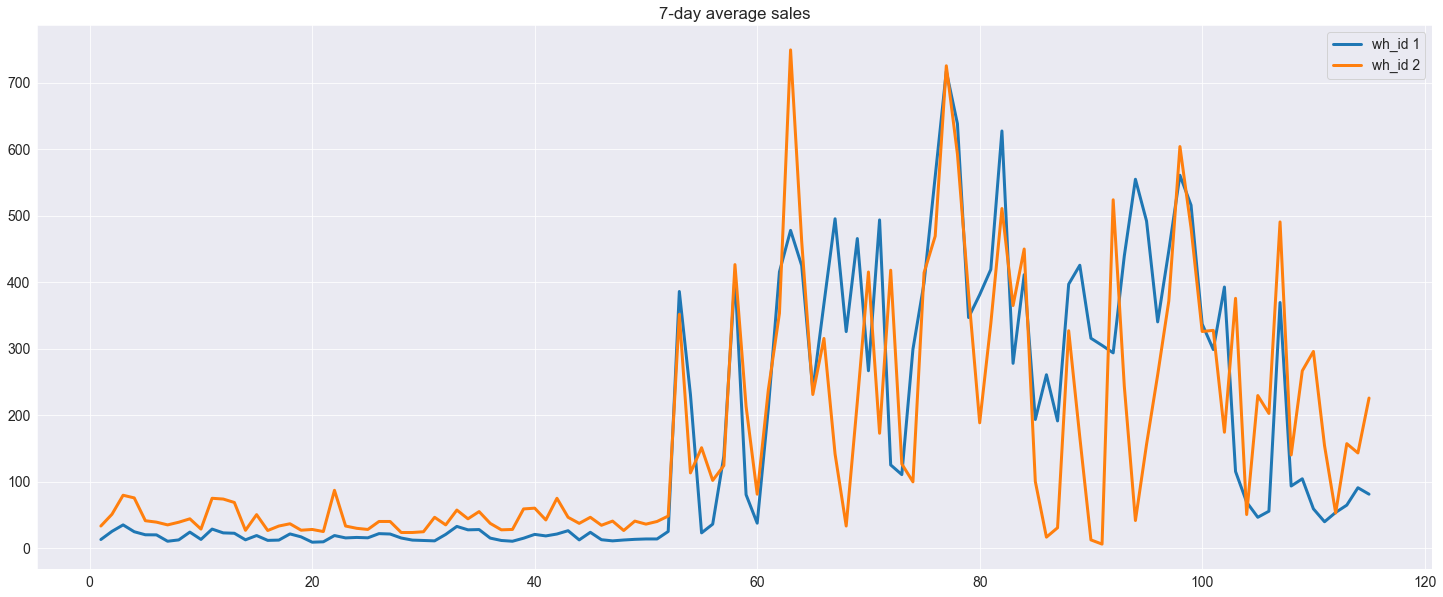

In [93]:
legend = []
for i in range(1,3):
    y = week_avg_wh_id(df1.wh_id.unique()[i])
    plt.plot(range(1,len(y)+1),y,linewidth = 3)
    legend.append('wh_id ' + str(i))
plt.legend(legend);
plt.title('7-day average sales');

We see the pattern of increase in the mid covid times and then decrease.

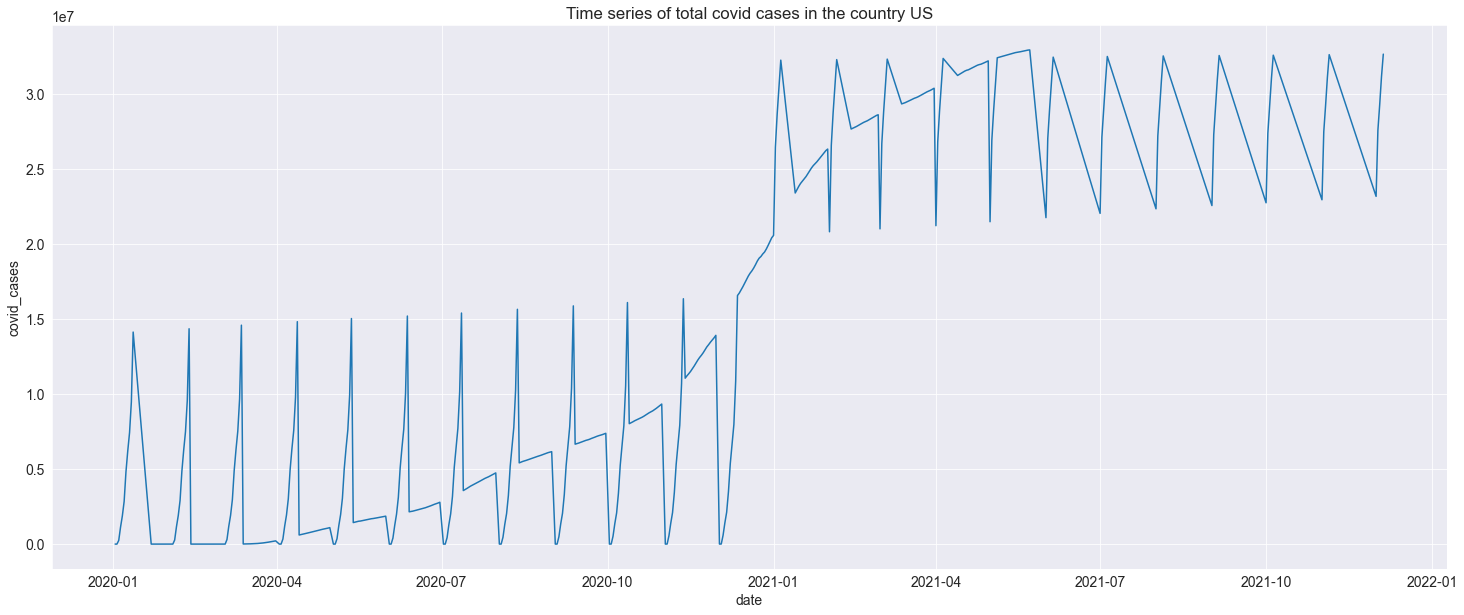

In [95]:
plt.plot(codf.date.unique(),codf.groupby('date').sum().tot_cases)
plt.title('Time series of total covid cases in the country US')
plt.xlabel('date')
plt.ylabel('covid_cases');

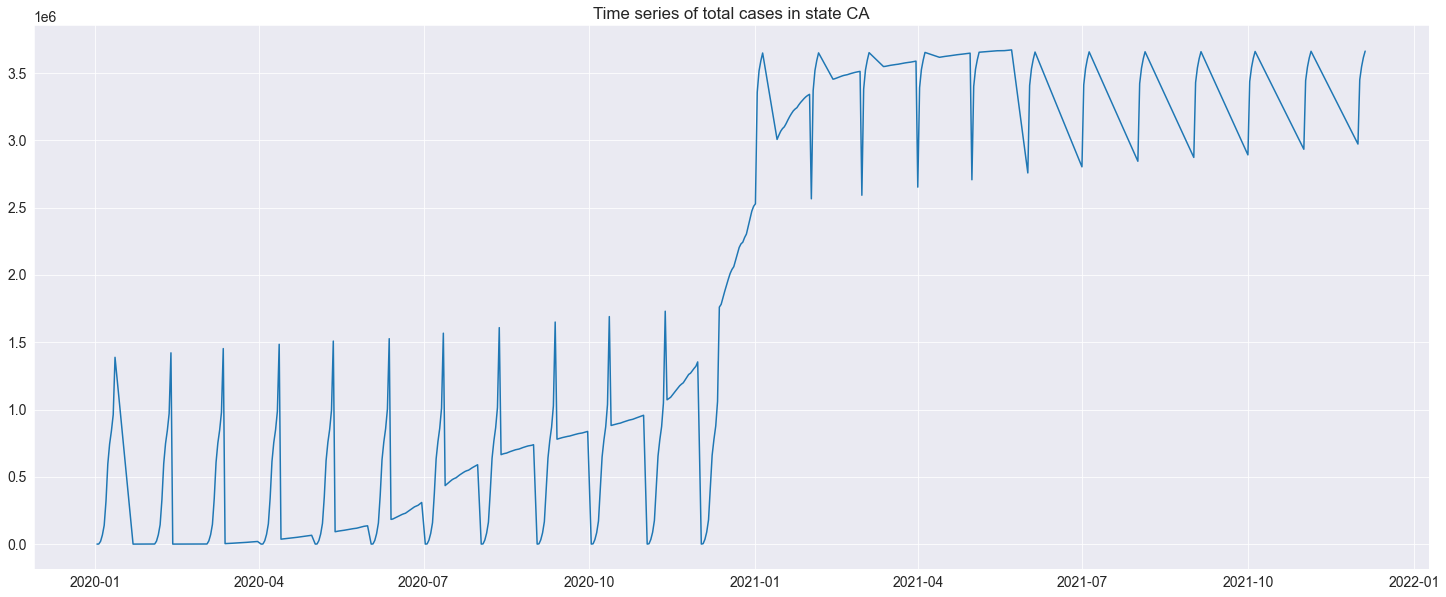

In [96]:
def cov_cases_state(state):
    plt.plot(codf[codf.state==state].date,codf[codf.state==state].tot_cases)
    plt.title('Time series of total cases in state '+state)
cov_cases_state('CA')

We see the thhe covid cases series as a whole and in one respective state is in the shape of sigmoid which peaked after a certain period.

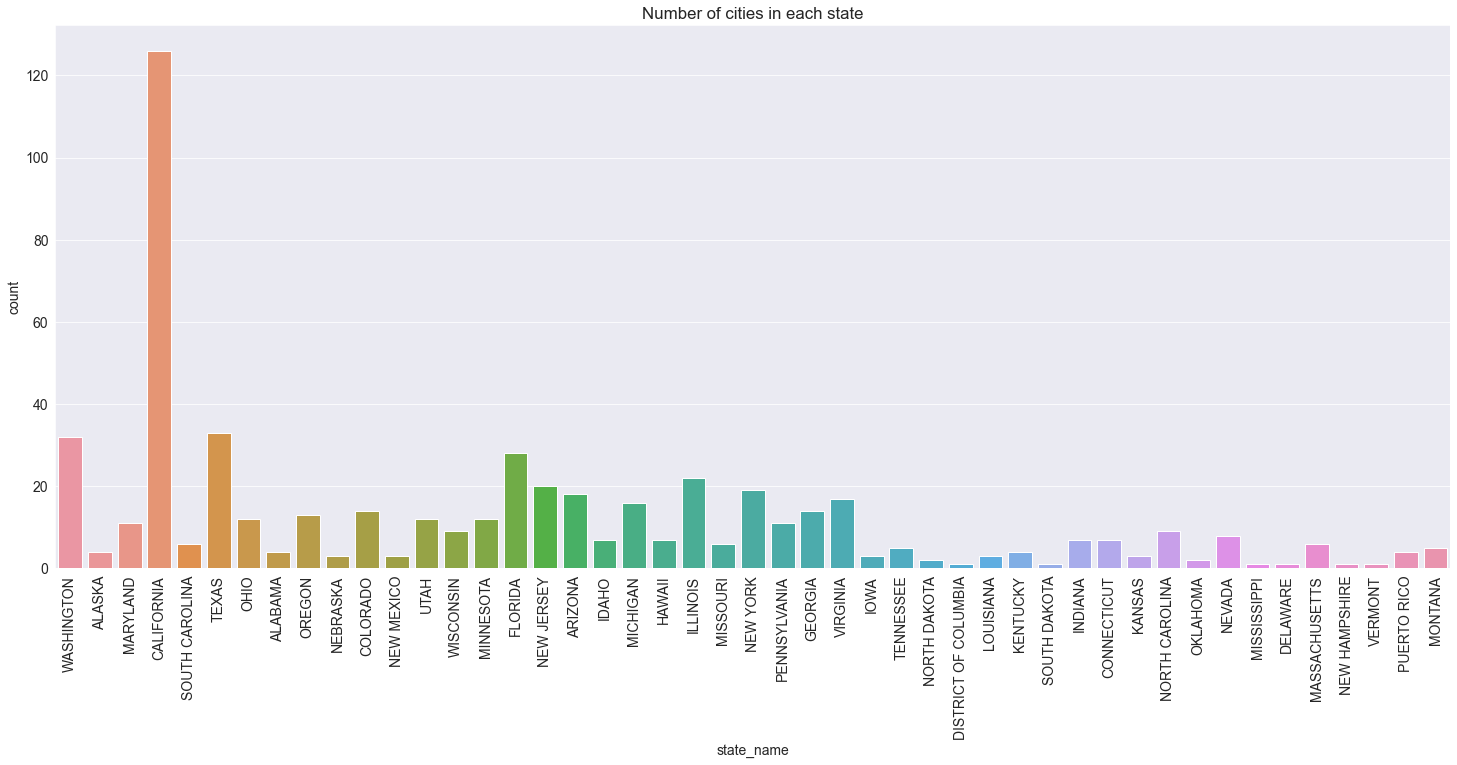

In [97]:
# State vs No.of cities
fig=sns.countplot(x=cidf_final.state_name);
plt.xticks(rotation=90);
plt.title('Number of cities in each state')
plt.show();

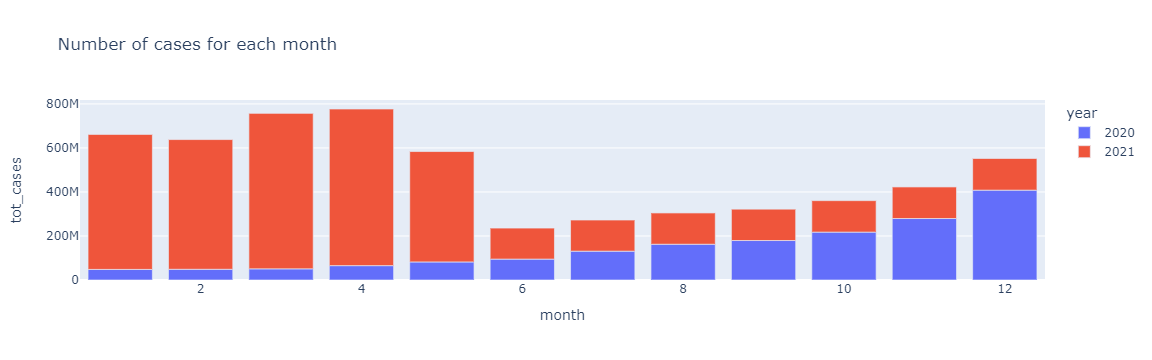

In [98]:
codf['month'] = codf.date.dt.month
cov_eda_2020 = codf[codf.date.dt.year == 2020].groupby('month').sum()
cov_eda_2020['year'],cov_eda_2020['month'] = '2020',cov_eda_2020.index
cov_eda_2021 = codf[codf.date.dt.year == 2021].groupby('month').sum()
cov_eda_2021['year'],cov_eda_2021['month'] ='2021',cov_eda_2021.index
cov_eda = pd.concat([cov_eda_2020,cov_eda_2021])
px.bar(cov_eda,x='month',y='tot_cases',color = 'year',title='Number of cases for each month')

We see that maximum cases in december for 2021 and april for 2022 which is period given in test data

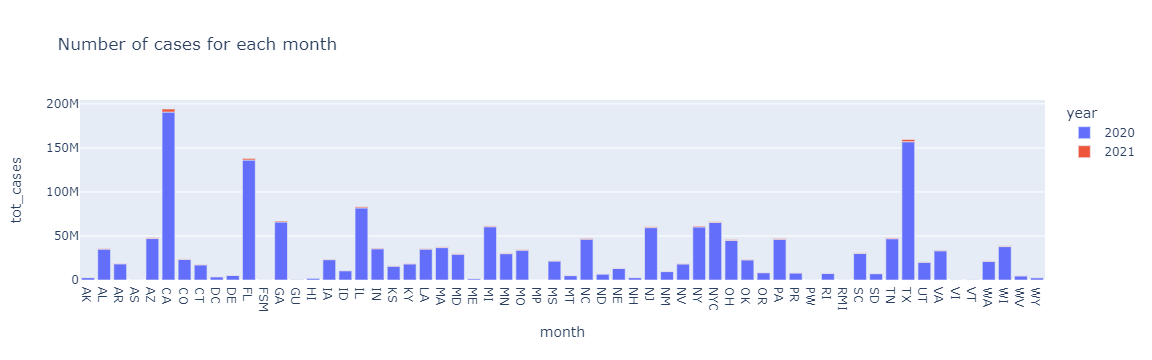

In [109]:
cov_eda_2020 = codf[codf.date.dt.year == 2020].groupby('state').sum()
cov_eda_2020['year'],cov_eda_2020['month'] = '2020',cov_eda_2020.index
cov_eda_2021 = codf[codf.date.dt.year == 2021].groupby('state').mean()
cov_eda_2021['year'],cov_eda_2021['month'] ='2021',cov_eda_2021.index
cov_eda = pd.concat([cov_eda_2020,cov_eda_2021])
px.bar(cov_eda,x='month',y='tot_cases',color = 'year',title='Number of cases for each month')

Seems more average covid month cases is high for 'CA' ,'TX

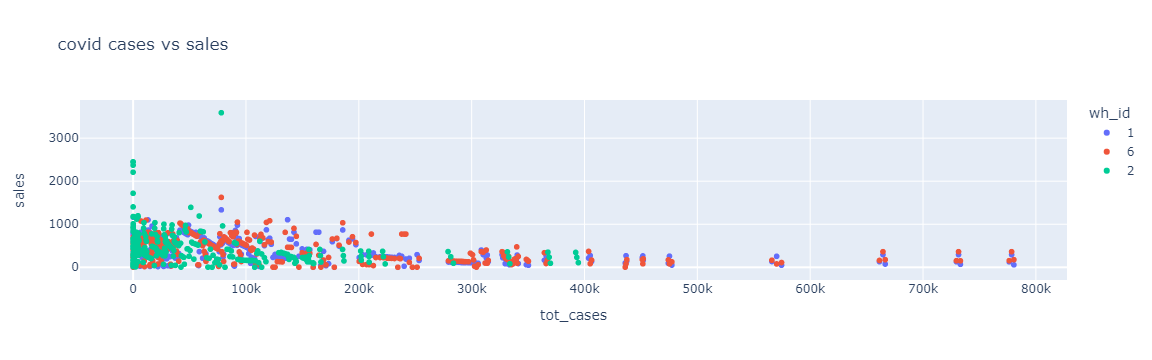

In [101]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[(cov.wh_id==1)|(cov.wh_id==2)|(cov.wh_id==6)], x="tot_cases", y="sales",
                 title='covid cases vs sales',color='wh_id')
fig.show()

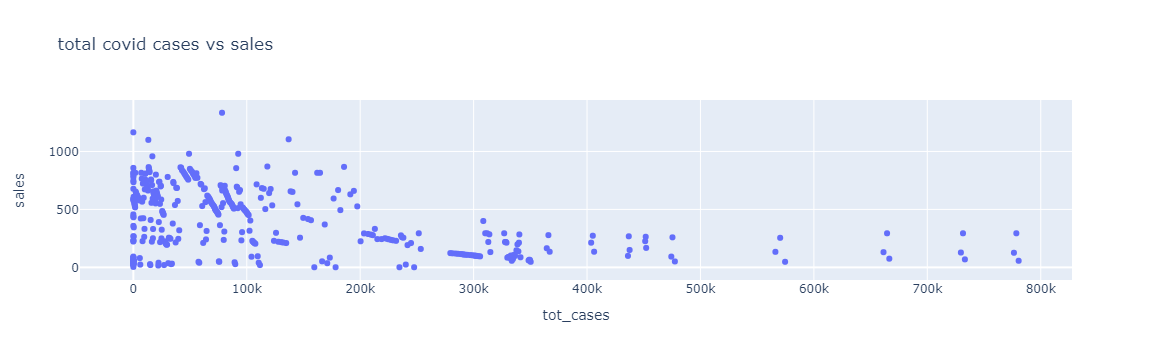

In [102]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[cov.wh_id==1], x="tot_cases", y="sales",
                 title='total covid cases vs sales')
fig.show()

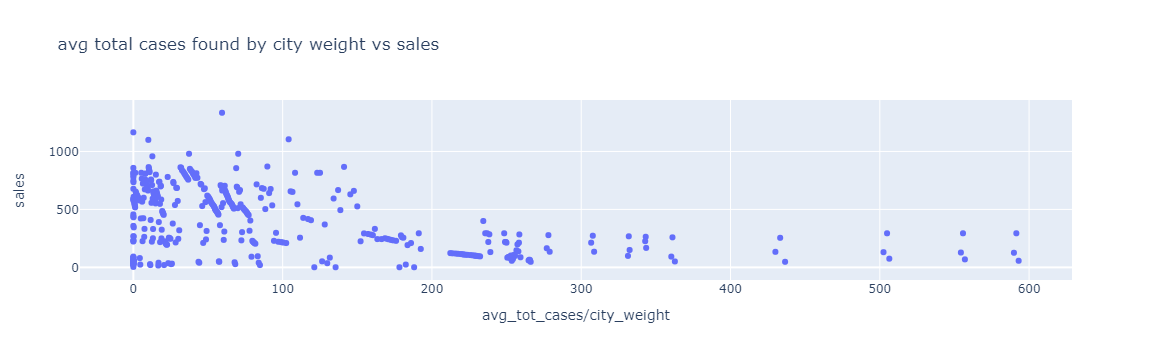

In [103]:
px.scatter(cov[cov.wh_id==1], x="avg_tot_cases/city_weight", y="sales",
                 title='avg total cases found by city weight vs sales')

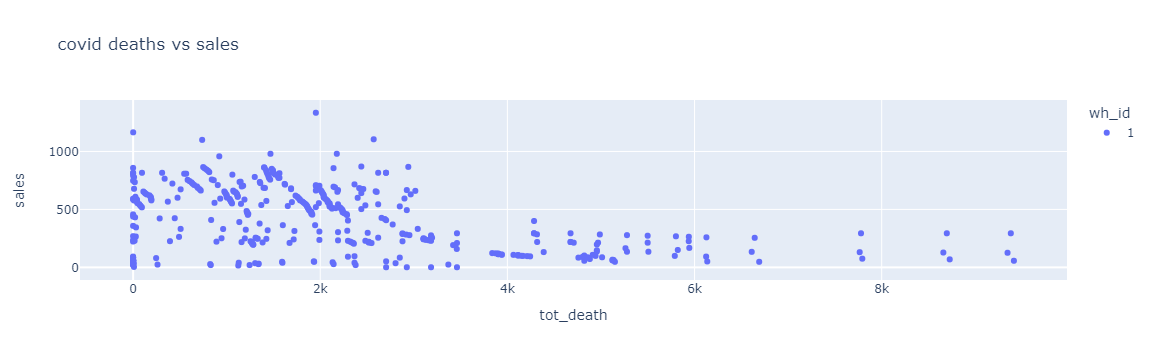

In [104]:
px.scatter(cov[cov.wh_id==1], x="tot_death", y="sales",
                 title='covid deaths vs sales',color='wh_id')

We see that there is approximately constant sles over a spread then decreases with both deaths,cases.

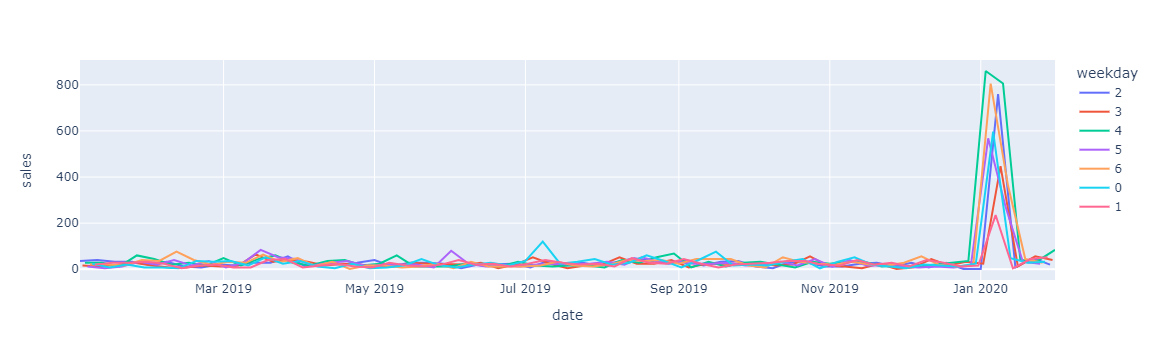

In [107]:
precov_eda = precov[precov.wh_id == 1][['date','sales']]
precov_eda.loc[:,'weekday']=precov.date.dt.weekday.astype('object')
px.line(precov_eda,x='date',y='sales',color='weekday')

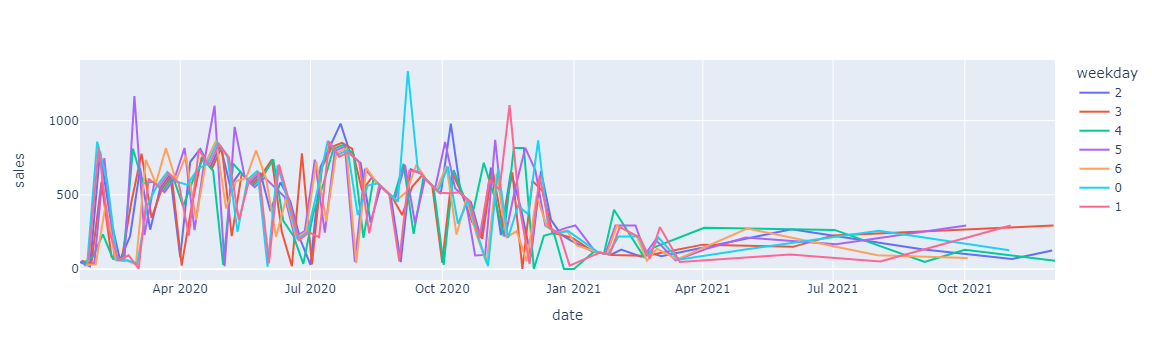

In [108]:
cov_eda = cov[cov.wh_id == 1][['date','sales']]
cov_eda.loc[:,'weekday']=cov.date.dt.weekday.astype('object')
px.line(cov_eda,x='date',y='sales',color='weekday')

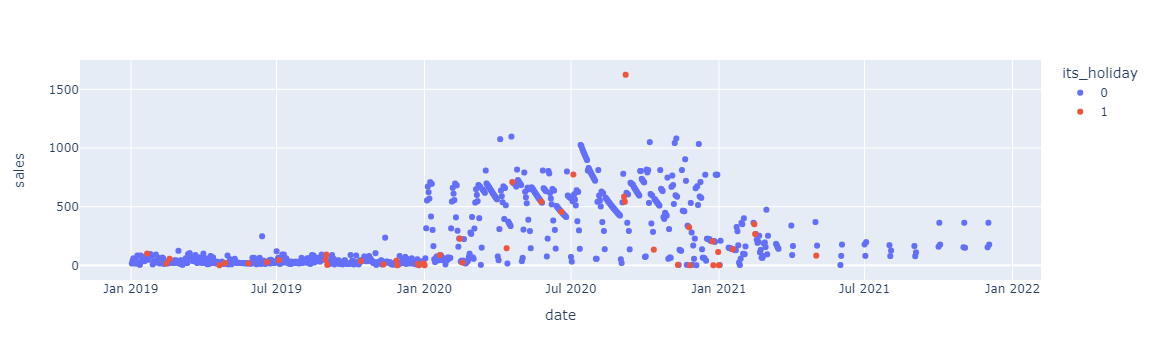

In [106]:
holiday_df.Date = pd.to_datetime(holiday_df.Date)
holiday_df['its_holiday'] = ['1']*holiday_df.shape[0]
hol_eda = z.merge(holiday_df[['Date','its_holiday']],right_on='Date',left_on='date',how='left')
hol_eda.fillna('0',inplace=True)
hol_eda = hol_eda[hol_eda.wh_id == 6][['date','sales','its_holiday']]
px.scatter(hol_eda,x='date',y='sales',color='its_holiday')

We see the effect of holidays in sales. Mainly the effect can be seen from preceeding daay sales of holidays.

## TRAINING

In [1143]:
import torch
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model

In [1126]:
z_test.sales=0
data_test = z_test[['wh_id','avg_tot_cases/city_weight','avg_tot_death/city_weight']]
data_train = z_train[['wh_id','avg_tot_cases/city_weight','avg_tot_death/city_weight','sales']]

In [1127]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
warehouses = np.sort(data_train.wh_id.unique())
for wh in warehouses:
  train_wh=data_train[data_train.wh_id==wh][['sales','avg_tot_cases/city_weight','avg_tot_death/city_weight']].values
  test_wh=data_test[data_test.wh_id==wh][['wh_id','avg_tot_cases/city_weight','avg_tot_death/city_weight']].values
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_wh = scaler.fit_transform(train_wh)
  test_wh=scaler.transform(test_wh)
  look_back = 15
  num_prediction=61
  trainX, trainY = create_dataset(train_wh, look_back=look_back)
  trainY=trainY.reshape(-1,1)
  model = Sequential()
  model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))
  model.add(LeakyReLU(alpha=0.5))
  model.add(LSTM(64,return_sequences=True))
  model.add(LeakyReLU(alpha=0.5))
  model.add(Dropout(0.2))
  model.add(LSTM(32,return_sequences=False))
  model.add(Dense(trainY.shape[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX,trainY, epochs=50, batch_size=1)
  prediction_list = train_wh[-look_back:]
  num_prediction=61
  for i in range(num_prediction):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, -1))
      out = model.predict(x)[0][0]
      prediction_list = np.concatenate((prediction_list,[[out,test_wh[i][0],test_wh[i][1]]]),axis=0)
  prediction_list = prediction_list[-num_prediction:]
  testPredict=prediction_list
  testPredict_nsc = scaler.inverse_transform(testPredict)[:,0]
  z_test.iloc[z_test[z_test.wh_id==wh].index,-1] = testPredict_nsc

In [ ]:
final_submission = df2.merge(z_test,on=['date','wh_id'],how='left')
final_submission[['date','wh_id','sales']].to_csv('final_submission.csv')